In [14]:
import torch
import torch.nn as nn
from dataloader import DataLoader

In [15]:
IMG_DIM = 28
MNIST_PATH = r"../mnist/"
EPOCHS = 200
BATCH_SIZE = 500
# LEARNING_RATE = 1e1
LEARNING_RATE = 1e-3
MOMENTUM = 1e-2
WEIGHT_DECAY = 0
CORRUPT_DATA = None
THRESHOLD = 0.04
NOISE_BOUND = 0.3


In [16]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(IMG_DIM * IMG_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, IMG_DIM * IMG_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        return decoded


In [17]:
""" 
Code taken from: https://stackoverflow.com/questions/53956932/use-pytorch-ssim-loss-function-in-my-model
creaete SSIMLoss class
"""
from piqa import SSIM
class SSIMLoss(SSIM):
    def forward(self, x, y):
        x = x.reshape(x.size(0), 1, IMG_DIM, IMG_DIM)
        y = y.reshape(y.size(0), 1, IMG_DIM, IMG_DIM)
        # Convert inte rbg, beacause SSIM requires it, grayscale to RGB: R = G = B = grayscale value 
        x = x.repeat(1,3,1,1) 
        y = y.repeat(1,3,1,1) 
        return 1. - super().forward(x, y)

In [18]:
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import time

model = Autoencoder()
# criterion = SSIMLoss()
criterion = nn.MSELoss() 
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    # momentum=MOMENTUM,
)
print(model.train())

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [19]:

writer = SummaryWriter("runs/simple_ae")

def train(train_loader, val_loader, epochs):
    

    tic = time.perf_counter()

    for epoch in range(1, epochs+1):
        train_loss = 0
        num_samples = 0
        for _, (image, _) in enumerate(train_loader):
            image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
            loss = criterion(reconstructed_image, image)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            num_samples += image.size(0) 

        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))
        
        train_loss = train_loss / num_samples
        _, _, val_loss = evaluate_batch(val_loader)
        
        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{epochs}, train_loss: {train_loss*100:.5f}, val_loss: {val_loss*100:.5f}")
        writer.add_scalar("train_mse_loss", train_loss, epoch)
        writer.add_scalar("val_mse_loss", val_loss, epoch)
        writer.add_images("original_image", image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")
        writer.add_images("reconstructed_image", reconstructed_image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")

def evaluate_batch(data_loader):
    with torch.no_grad():
        tot_loss = 0
        num_samples = 0
        for _, (images, label) in enumerate(data_loader):
            images = images.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(images)
            tot_loss += criterion(reconstructed_image, images).item()
            num_samples += images.size(0)
        loss = tot_loss / num_samples
    return images, reconstructed_image, loss

def evaluate_image(data_loader):
    with torch.no_grad():
        out = []
        for _, (images, labels) in enumerate(data_loader):
            for image, label in zip(images, labels):
                image = image.reshape(1, IMG_DIM*IMG_DIM)
                reconstructed_image = model(image)
                loss = criterion(reconstructed_image, image).item()
                out.append((image.numpy(), reconstructed_image.numpy(), loss, label.item()))
    return out

def predict(data_loader, threshold):
    out = evaluate_image(data_loader)
    labels = [element[3] for element in out]
    preds = [int(element[2] < threshold) for element in out]
    return preds, labels

In [20]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=1000, num_anomaly_data=100, corrupt_train=CORRUPT_DATA, noise_bound=NOISE_BOUND)
train_loader, val_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=BATCH_SIZE)


In [21]:
train(train_loader, normal_loader, epochs=EPOCHS)
writer.flush()

Time elapsed: 00:00, epoch: 01/200, train_loss: 0.04348, val_loss: 0.03513
Time elapsed: 00:00, epoch: 02/200, train_loss: 0.02399, val_loss: 0.01663
Time elapsed: 00:00, epoch: 03/200, train_loss: 0.01530, val_loss: 0.01514
Time elapsed: 00:01, epoch: 04/200, train_loss: 0.01469, val_loss: 0.01489
Time elapsed: 00:01, epoch: 05/200, train_loss: 0.01445, val_loss: 0.01462
Time elapsed: 00:02, epoch: 06/200, train_loss: 0.01425, val_loss: 0.01438
Time elapsed: 00:02, epoch: 07/200, train_loss: 0.01398, val_loss: 0.01404
Time elapsed: 00:02, epoch: 08/200, train_loss: 0.01356, val_loss: 0.01354
Time elapsed: 00:03, epoch: 09/200, train_loss: 0.01302, val_loss: 0.01298
Time elapsed: 00:03, epoch: 10/200, train_loss: 0.01252, val_loss: 0.01248
Time elapsed: 00:04, epoch: 11/200, train_loss: 0.01206, val_loss: 0.01208
Time elapsed: 00:04, epoch: 12/200, train_loss: 0.01170, val_loss: 0.01173
Time elapsed: 00:05, epoch: 13/200, train_loss: 0.01134, val_loss: 0.01126
Time elapsed: 00:05, epoc

In [22]:
MODEL_PATH = r"model/adam_simple_ae.pt"
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)

mean loss for normal data: 0.011333090431406163, std: 0.006338145279870628


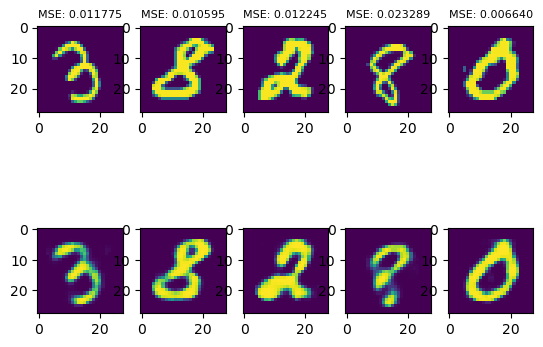

mean loss for anomaly data: 0.13441928699612618, std: 0.0174662577354665


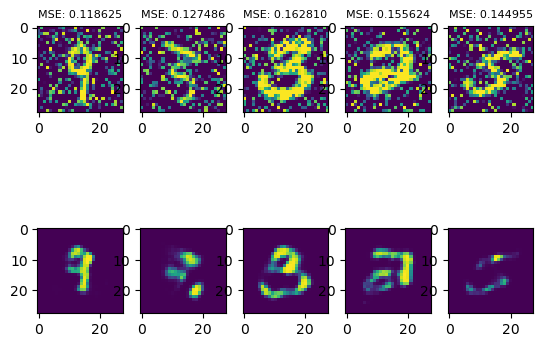

In [23]:
import matplotlib.pyplot as plt
import numpy as np

FIGURE_FONT_SIZE = 8
fig = plt.figure()
out = evaluate_image(normal_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])
print(f"mean loss for normal data: {mean_loss}, std: {std_loss}")

plt.savefig(f"SSIM_normal_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

fig = plt.figure()
out = evaluate_image(anomaly_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])

print(f"mean loss for anomaly data: {mean_loss}, std: {std_loss}")

plt.savefig(f"SSIM_anomaly_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()